# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2019

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import utils
import os
from random import randint
import math
from pprint import pprint

In [5]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

<IPython.core.display.Javascript object>


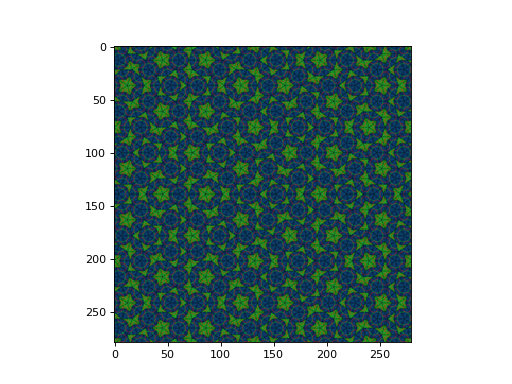

In [229]:
#https://images-na.ssl-images-amazon.com/images/I/81p-%2Bkp6%2BRL._AC_SL1500_.jpg bricks
#https://images.theconversation.com/files/133922/original/image-20160812-16339-v2g90o.png?ixlib=rb-1.1.0&q=45&auto=format&w=496&fit=clip cool patters
sample_img_dir = 'samples/cool_pattern.jpg' # feel free to change
sample_img = None
if os.path.exists(sample_img_dir):
    sample_img = cv2.imread(sample_img_dir)
    sample_img = cv2.cvtColor(sample_img,cv2.COLOR_BGR2RGB)
    fig, axes = plt.subplots(1, 1)
    axes.imshow(sample_img)

<IPython.core.display.Javascript object>


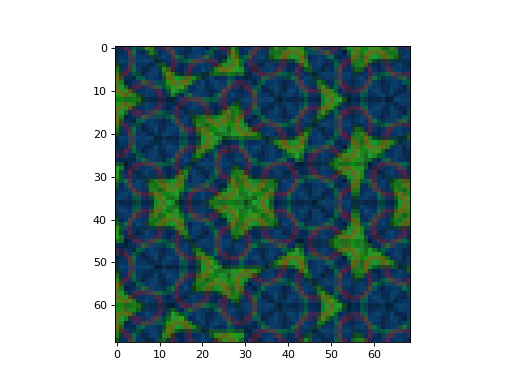

In [230]:
def sample_image(width,sample_img):
    row = sample_img.shape[0]
    column = sample_img.shape[1]
    random_row = randint(0,row - width)
    random_column = randint(0,column - width)
    new = sample_img[random_row:random_row + width,random_column:random_column + width,:]
    return new


fig, axes = plt.subplots(1, 1)
axes.imshow(sample_image(69,sample_img))


In [231]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    size = out_size
    output = np.zeros(shape=(size,size,3))
    new = sample_image(patch_size,sample_img) 
    y = 0
    size_patch = new.shape[0]
    while y < size:
        x = 0
        while x < size:
            if x + size_patch > size and y + size_patch > size:
                new = sample_image(patch_size,sample_img)
                output[y:size,x:size] = new[0:size-y,0:size-x]
                break
            if x + size_patch > size:
                new = sample_image(patch_size,sample_img)
                output[y:size_patch+y,x:size] = new[:,0:size-x]
                break
            if y + size_patch > size:
                new = sample_image(patch_size,sample_img)
                output[y:size,x:size_patch+x] = new[0:size-y,:]
                x += size_patch
            else:
                new = sample_image(patch_size,sample_img)
                output[y:size_patch+y,x:size_patch+x] = new
                x += size_patch
        y += size_patch
    output = output.astype('uint8')
    return output

<IPython.core.display.Javascript object>


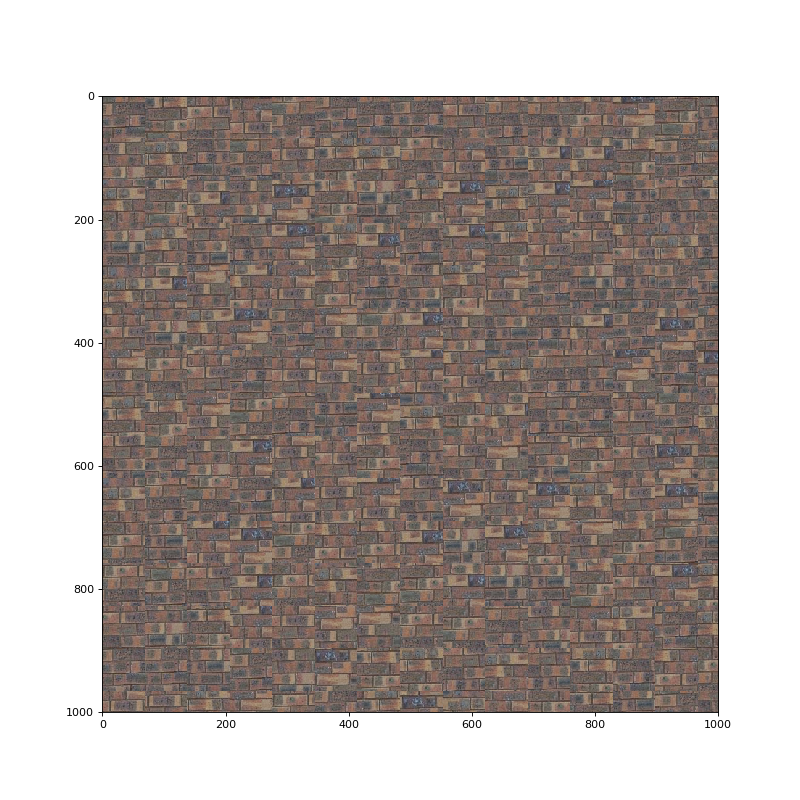

In [249]:
out_size = 1000 # feel free to change to debug
patch_size = 69 # feel free to change to debug
res = quilt_random(sample_img, out_size, patch_size)
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
axes.imshow(res)
plt.savefig('bricks_small_random.png')

### Part II: Overlapping Patches (30 pts)

In [234]:
def ssd_patch_left(overlap,left_patch,patch_size):
    M = np.zeros(shape=(patch_size,patch_size,3))
    M[:,:overlap,:] = 1
    T = np.zeros(shape=(patch_size,patch_size,3))
    T[:,:overlap,:] = left_patch[:, patch_size-overlap:patch_size,:] #template overlap real values
    T/255.0
    I = sample_img/255.0
    ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    return ssd

In [235]:
def ssd_patch_up(overlap,up_patch,patch_size):
    M = np.zeros(shape=(patch_size,patch_size,3))
    M[:overlap,:,:] = 1
    T = np.zeros(shape=(patch_size,patch_size,3))
    test = up_patch[patch_size-overlap:patch_size, :,:]
    test_2 = T[:overlap,:,:]
    T[:overlap,:,:] = up_patch[patch_size-overlap:patch_size, :,:] #template overlap real values
    T/255.0
    I = sample_img/255.0
    ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    return ssd

In [236]:
def choose_sample(k,ssd,overlap,patch_size,input_image):
    input_image_size = input_image.shape[0]
    #print(input_image_size)
    row = []
    col = []
    z = []
    while len(row) < k:
        row_1, col_1, z_1 = np.where(ssd == np.amin(ssd))
        if (patch_size-1)/2<row_1[0] < input_image_size-((patch_size-1)/2) and (patch_size-1)/2<col_1[0] < input_image_size-((patch_size-1)/2):
            row.append(row_1[0])
            col.append(col_1[0])
            z.append(z_1[0])
        ssd[row_1,col_1,z_1] = 10000000000000
    #print (row, col, z)
    rand_int = randint(0,k-1)
    return input_image[row[rand_int]-int(((patch_size-1)/2)):(row[rand_int]-int((patch_size-1)/2))+patch_size,col[rand_int]-int((patch_size-1)/2):(col[rand_int]-int((patch_size-1)/2))+patch_size,:]

In [237]:
def quilt_simple(sample, out_size, patch_size, overlap, k):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param k: int how many random samples to choose from smallest ssd values.
    :return: numpy.ndarray
    """
    output = np.zeros(shape=(out_size,out_size,3))
    y = 0
    t = 0
    print(t)
    while y < out_size:
        x = 0
        while x < out_size:
            if y == 0 and x == 0: #1
                random_sample = sample_image(patch_size,sample)
                output[:patch_size,:patch_size,:] = random_sample
                x += patch_size
                print(y,x)
            elif y ==0 and x + patch_size <= out_size: #2
                left_patch = output[y:patch_size,x-patch_size:x,:]
                ssd = ssd_patch_left(overlap,left_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:patch_size,x:x+patch_size,:] = out
                x += patch_size
                print(y,x)
            elif y ==0 and x + patch_size > out_size:
                left_patch = output[y:patch_size,x-patch_size:x,:]
                ssd = ssd_patch_left(overlap,left_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:patch_size,x:out_size,:] = out[:,:out_size-x,:]
                y += patch_size
                x = out_size + 1
                print(y,x)
            elif y + patch_size <= out_size and x == 0:
                up_patch = output[y-patch_size:y,x:x+patch_size,:]
                ssd = ssd_patch_up(overlap,up_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:y+patch_size,x:x+patch_size,:] = out
                x += patch_size
                print(y,x)
            elif y + patch_size <= out_size and x + patch_size <= out_size:
                up_patch = output[y-patch_size:y,x:x+patch_size,:]
                left_patch = output[y:patch_size+y,x-patch_size:x,:]
                ssd_1 = ssd_patch_left(overlap,left_patch,patch_size)
                ssd_2  = ssd_patch_up(overlap,up_patch,patch_size)
                ssd = ssd_1 + ssd_2
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:y+patch_size,x:x+patch_size,:] = out
                x += patch_size
                print(y,x)
            elif y + patch_size <= out_size and x + patch_size > out_size:
                up_patch = np.zeros(shape=(patch_size,patch_size,3))
                up_patch[:,:out_size-x,:] = output[y-patch_size:y,x:out_size,:]
                left_patch = output[y:patch_size+y,x-patch_size:x,:]
                ssd_1 = ssd_patch_left(overlap,left_patch,patch_size)
                ssd_2  = ssd_patch_up(overlap,up_patch,patch_size)
                ssd = ssd_1 + ssd_2
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:y+patch_size,x:x+patch_size,:] = out[:,:out_size-x,:]
                x = out_size + 1
                y = y + patch_size
                print(y,x)
            elif y + patch_size > out_size and x == 0:
                up_patch = output[y-patch_size:y,x:x+patch_size,:]
                ssd = ssd_patch_up(overlap,up_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:out_size,x:x+patch_size,:] = out[:out_size-y,:,:]
                x += patch_size
                print(y,x)
            elif y + patch_size > out_size and x + patch_size <= out_size:
                up_patch = output[y-patch_size:y,x:x+patch_size,:]
                left_patch = np.zeros(shape=(patch_size,patch_size,3))
                left_patch[:out_size-y,:,:] = output[y:out_size,x-patch_size:x,:]
                ssd_1 = ssd_patch_left(overlap,left_patch,patch_size)
                ssd_2  = ssd_patch_up(overlap,up_patch,patch_size)
                ssd = ssd_1 + ssd_2
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:y+patch_size,x:x+patch_size,:] = out[:out_size-y,:,:]
                x += patch_size
                print(y,x)
            elif y + patch_size > out_size and x + patch_size > out_size:
                up_patch = np.zeros(shape=(patch_size,patch_size,3))
                up_patch[:,:out_size-x,:] = output[y-patch_size:y,x:out_size,:]
                left_patch = np.zeros(shape=(patch_size,patch_size,3))
                left_patch[:out_size-y,:,:] = output[y:out_size,x-patch_size:x,:]
                ssd_1 = ssd_patch_left(overlap,left_patch,patch_size)
                ssd_2  = ssd_patch_up(overlap,up_patch,patch_size)
                ssd = ssd_1 + ssd_2
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:y+patch_size,x:x+patch_size,:] = out[:out_size-y,:out_size-x,:]
                x += patch_size
                return output
                




0
0 69
0 138
0 207
0 276
0 345
0 414
0 483
0 552
0 621
0 690
0 759
0 828
0 897
0 966
69 1001
69 69
69 138
69 207
69 276
69 345
69 414
69 483
69 552
69 621
69 690
69 759
69 828
69 897
69 966
138 1001
138 69
138 138
138 207
138 276
138 345
138 414
138 483
138 552
138 621
138 690
138 759
138 828
138 897
138 966
207 1001
207 69
207 138
207 207
207 276
207 345
207 414
207 483
207 552
207 621
207 690
207 759
207 828
207 897
207 966
276 1001
276 69
276 138
276 207
276 276
276 345
276 414
276 483
276 552
276 621
276 690
276 759
276 828
276 897
276 966
345 1001
345 69
345 138
345 207
345 276
345 345
345 414
345 483
345 552
345 621
345 690
345 759
345 828
345 897
345 966
414 1001
414 69
414 138
414 207
414 276
414 345
414 414
414 483
414 552
414 621
414 690
414 759
414 828
414 897
414 966
483 1001
483 69
483 138
483 207
483 276
483 345
483 414
483 483
483 552
483 621
483 690
483 759
483 828
483 897
483 966
552 1001
552 69
552 138
552 207
552 276
552 345
552 414
552 483
552 552
552 621
552 690
55

<IPython.core.display.Javascript object>


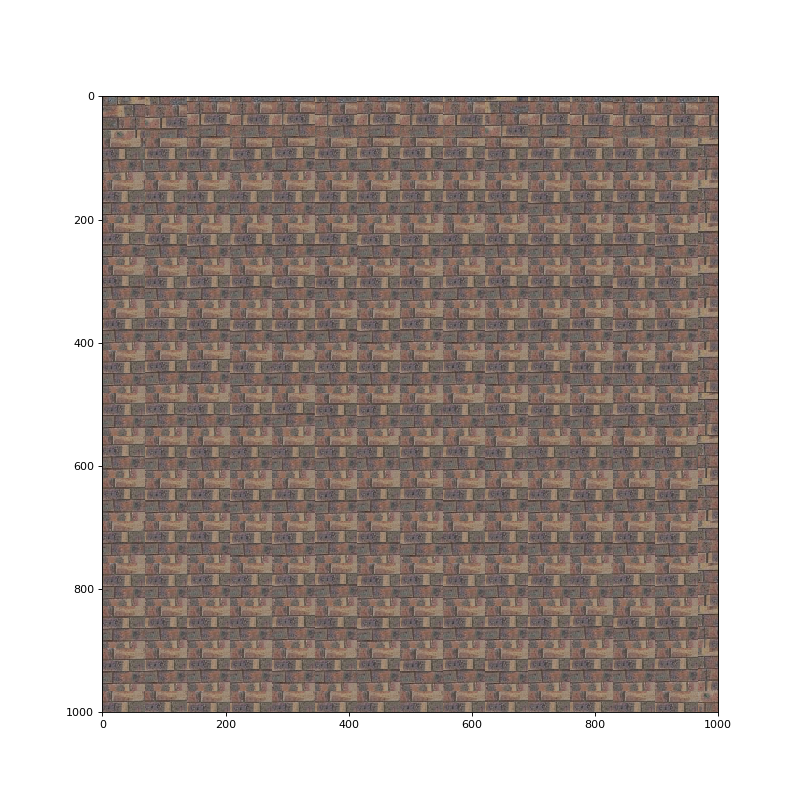

In [250]:
output = quilt_simple(sample_img, 1000, 69, 10, 20)
output = output.astype('uint8')
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
axes.imshow(output)
plt.savefig('bricks_small_overlapping_patches.png')

### Part III: Seam Finding (20 pts)


<IPython.core.display.Javascript object>


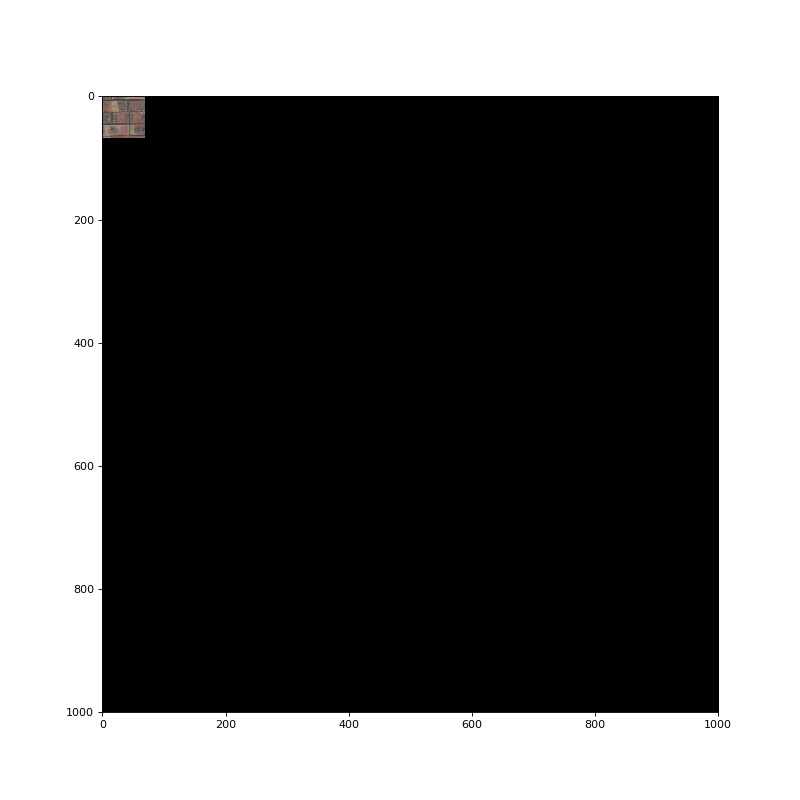

In [251]:
size = 69
sample_image_1 = sample_image(size,sample_img)
size_image = 1000
output = np.zeros(shape=(size_image,size_image,3))
output[:size,:size] = sample_image_1
output = output.astype('uint8')
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
axes.imshow(output)


In [252]:
ssd = ssd_patch_up(10,sample_image_1,51)
sample = choose_sample(20,ssd,10,51,sample_img) 
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(5, 5)
axes.imshow(sample)
sample.shape

ValueError: could not broadcast input array from shape (10,69,3) into shape (10,51,3)

In [253]:
#sum of squasres dif
A = sample_image_1[51-10:51,:,:]
B = sample[:10,:,:]
s = (A[:,:,:]-B[:,:,:])**2
s = s[:,:,0] + s[:,:,1] + s[:,:,2]
#s = s.transpose()
s.shape

ValueError: operands could not be broadcast together with shapes (10,69,3) (10,51,3) 

In [254]:
#get cut
mask = cut(s)

#mask = mask.transpose()
pprint(mask)



array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [255]:
mask = list(mask)

In [256]:

output_in = np.zeros(shape=(51,10,3))
row = 0
col = 0
for x in mask:
    col = 0
    for y in x:
        if y == 0:
            output_in[row,col,:] = A[row,col,:]
        else:
            output_in[row,col,:] = B[row,col,:]
        #print(row,col)
        col += 1
    row += 1
    
            
            
  
    

IndexError: index 10 is out of bounds for axis 1 with size 10

<IPython.core.display.Javascript object>


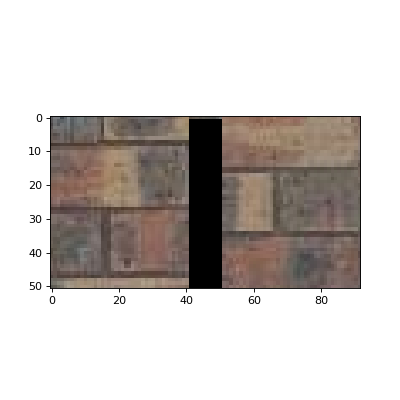

In [257]:
test = output[0:51,51-10:51,:]
test.shape
output[0:51,51-10:51,:] = output_in
output[0:51,51:92,:]=sample[:,10:51,:]

output = output.astype('uint8')
new = output[0:51,0:92,:]
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(5, 5)
axes.imshow(new)

In [258]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [174]:
def overlap_patch(A,B,overlap,patch_size):
    A = A[:,patch_size-overlap:patch_size,:]
    B = B[:,:overlap,:]
    s = (A[:,:,:]-B[:,:,:])**2
    s = s[:,:,0] + s[:,:,1] + s[:,:,2]
    s =  s.transpose()
    mask = cut(s)
    mask = mask.transpose()
    output_in = np.zeros(shape=(patch_size,overlap,3))
    row = 0
    col = 0
    for x in mask:
        col = 0
        for y in x:
            if y == 0:
                output_in[row,col,:] = A[row,col,:]
            else:
                output_in[row,col,:] = B[row,col,:]
            #print(row,col)
            col += 1
        row += 1
    return output_in

In [175]:
def overlap_patch_up(A,B,overlap,patch_size):
    A = A[patch_size-overlap:patch_size,:patch_size,:]
    B = B[:overlap,:,:]
    s = (A[:,:,:]-B[:,:,:])**2
    s = s[:,:,0] + s[:,:,1] + s[:,:,2]
    mask = cut(s)
    output_in = np.zeros(shape=(overlap,patch_size,3))
    row = 0
    col = 0
    for x in mask:
        col = 0
        for y in x:
            if y == 0:
                output_in[row,col,:] = A[row,col,:]
            else:
                output_in[row,col,:] = B[row,col,:]
            #print(row,col)
            col += 1
        row += 1
    return output_in

In [176]:
def overlap_patch_left_up(A,B,overlap,patch_size):
    A = A[patch_size-overlap:patch_size,overlap:,:]
    B = B[:overlap,overlap:,:]
    s = (A[:,:,:]-B[:,:,:])**2
    s = s[:,:,0] + s[:,:,1] + s[:,:,2]
    mask = cut(s)
    output_in = np.zeros(shape=(overlap,patch_size-overlap,3))
    row = 0
    col = 0
    for x in mask:
        col = 0
        for y in x:
            if y == 0:
                output_in[row,col,:] = A[row,col,:]
            else:
                output_in[row,col,:] = B[row,col,:]
            #print(row,col)
            col += 1
        row += 1
    return output_in

In [177]:
def ssd_patch_left_2(overlap,left_patch,patch_size):
    M = np.zeros(shape=(patch_size-overlap,patch_size,3))
    M[:,:overlap,:] = 1
    T = np.zeros(shape=(patch_size-overlap,patch_size,3))
    T[:,:overlap,:] = left_patch[:, patch_size-overlap:patch_size,:] #template overlap real values
    T/255.0
    I = sample_img/255.0
    ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    return ssd

In [242]:
def quilt_cut(sample, out_size, patch_size, overlap, k):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    output = np.zeros(shape=(out_size,out_size,3))
    t = 0
    y = 0 #the current row value
    while y < out_size:
        x = 0 #current column value 
        while x < out_size:
            if y == 0 and x == 0: #1
                random_sample = sample_image(patch_size,sample)
                output[:patch_size,:patch_size,:] = random_sample
                x += patch_size
                print(y,x)
            elif y ==0 and x + patch_size - overlap <= out_size: #2
                left_patch = output[y:patch_size,x-patch_size:x,:]
                ssd = ssd_patch_left(overlap,left_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output_in = overlap_patch(left_patch,out,overlap,patch_size)
                output[y:y+patch_size,x-overlap:x,:] = output_in
                output[y:y+patch_size,x:x+patch_size-overlap,:]=out[:,overlap:patch_size,:]
                x += patch_size - overlap
                print(y,x)
            elif y ==0 and x + patch_size - overlap > out_size: #3
                left_patch = output[y:patch_size,x-patch_size:x,:]
                ssd = ssd_patch_left(overlap,left_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output_in = overlap_patch(left_patch,out,overlap,patch_size)
                output[y:y+patch_size,x-overlap:x,:] = output_in
                output[y:y+patch_size,x:out_size,:]=out[:,overlap:out_size - x + overlap,:]
                x = out_size + 1
                y += patch_size
                print(y,x)
            elif y + patch_size <= out_size and x == 0: #4
                up_patch = output[y-patch_size:y,x:x+patch_size,:]
                ssd = ssd_patch_up(overlap,up_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output_in = overlap_patch_up(up_patch,out,overlap,patch_size)
                output[y-overlap:y,x:x+patch_size,:] = output_in
                output[y:y+patch_size-overlap,x:x+patch_size,:] = out[overlap:patch_size,:,:]
                x += patch_size
                print(y,x)
            elif y + patch_size <= out_size and x + patch_size <= out_size: #5
                up_patch = output[y-patch_size:y,x:x+patch_size,:]
                left_patch = output[y:y+patch_size,x-patch_size:x,:]

                ssd_1 = ssd_patch_up(overlap,up_patch,patch_size)
                ssd_2 = ssd_patch_left(overlap,left_patch,patch_size)
                ssd = ssd_1 + ssd_2
                
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                #left

                output_in = overlap_patch(left_patch,out,overlap,patch_size)
                output[y:y+patch_size-overlap,x-overlap:x,:] = output_in[:patch_size-overlap,:,:]
                
                #up
                output_in = overlap_patch_left_up(up_patch,out,overlap,patch_size)
                output[y:y+overlap,x:x+patch_size-overlap,:] = output_in[:,:patch_size-overlap,:]
                output[y+overlap:y+patch_size-overlap,x:x+patch_size-overlap,:] = out[overlap:patch_size-overlap,overlap:patch_size,:]
                x += patch_size - overlap
                print(y,x)
            elif y + patch_size <= out_size and x + patch_size > out_size: #6
                #need to blend
                up_patch = np.zeros(shape=(patch_size,patch_size,3))
                up_patch[:,:out_size-x,:] = output[y-patch_size:y,x:out_size,:]
                left_patch = output[y:patch_size+y,x-patch_size:x,:]
                ssd_1 = ssd_patch_left(overlap,left_patch,patch_size)
                ssd_2  = ssd_patch_up(overlap,up_patch,patch_size)
                ssd = ssd_1 + ssd_2
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:y+patch_size-overlap,x:x+patch_size,:] = out[:patch_size-overlap,:out_size-x,:]
                x = 1 + out_size
                y = y + patch_size - overlap
                print(y,x)
            elif y + patch_size > out_size and x == 0: #7
                #need to blend
                up_patch = output[y-patch_size:y,x:x+patch_size,:]
                ssd = ssd_patch_up(overlap,up_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:out_size,x:x+patch_size,:] = out[:out_size-y,:,:]
                x += patch_size
                print(y,x)
            elif y + patch_size > out_size and x + patch_size <= out_size: #8
                 #need to blend
                up_patch = output[y-patch_size:y,x:x+patch_size,:]
                left_patch = np.zeros(shape=(patch_size,patch_size,3))
                left_patch[:out_size-y,:,:] = output[y:out_size,x-patch_size:x,:]
                ssd_1 = ssd_patch_left(overlap,left_patch,patch_size)
                ssd_2  = ssd_patch_up(overlap,up_patch,patch_size)
                ssd = ssd_1 + ssd_2
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:y+patch_size,x:x+patch_size,:] = out[:out_size-y,:,:]
                x += patch_size
                print(y,x)
            elif y + patch_size > out_size and x + patch_size > out_size: #9
                #need to blend
                up_patch = np.zeros(shape=(patch_size,patch_size,3))
                up_patch[:,:out_size-x,:] = output[y-patch_size:y,x:out_size,:]
                left_patch = np.zeros(shape=(patch_size,patch_size,3))
                left_patch[:out_size-y,:,:] = output[y:out_size,x-patch_size:x,:]
                ssd_1 = ssd_patch_left(overlap,left_patch,patch_size)
                ssd_2  = ssd_patch_up(overlap,up_patch,patch_size)
                ssd = ssd_1 + ssd_2
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:y+patch_size,x:x+patch_size,:] = out[:out_size-y,:out_size-x,:]
                x += patch_size
                return output
            else:
                return output
                
                
            
                
                
    
                

0 69
0 128
0 187
0 246
0 305
0 364
0 423
0 482
0 541
0 600
0 659
0 718
0 777
0 836
0 895
0 954
69 1001
69 69
69 128
69 187
69 246
69 305
69 364
69 423
69 482
69 541
69 600
69 659
69 718
69 777
69 836
69 895
69 954
128 1001
128 69
128 128
128 187
128 246
128 305
128 364
128 423
128 482
128 541
128 600
128 659
128 718
128 777
128 836
128 895
128 954
187 1001
187 69
187 128
187 187
187 246
187 305
187 364
187 423
187 482
187 541
187 600
187 659
187 718
187 777
187 836
187 895
187 954
246 1001
246 69
246 128
246 187
246 246
246 305
246 364
246 423
246 482
246 541
246 600
246 659
246 718
246 777
246 836
246 895
246 954
305 1001
305 69
305 128
305 187
305 246
305 305
305 364
305 423
305 482
305 541
305 600
305 659
305 718
305 777
305 836
305 895
305 954
364 1001
364 69
364 128
364 187
364 246
364 305
364 364
364 423
364 482
364 541
364 600
364 659
364 718
364 777
364 836
364 895
364 954
423 1001
423 69
423 128
423 187
423 246
423 305
423 364
423 423
423 482
423 541
423 600
423 659
423 718
42

<IPython.core.display.Javascript object>


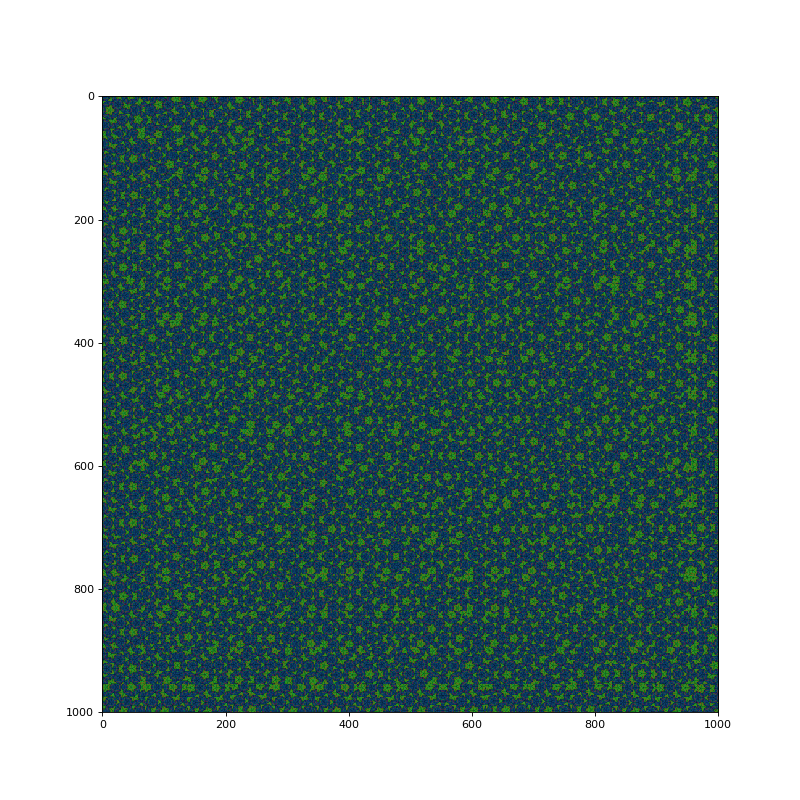

In [243]:
output = quilt_cut(sample_img, 1000, 69, 10, 20)
output = output.astype('uint8')
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
axes.imshow(output)
plt.savefig('cool_pattern_seam_finding.png')

0 301
0 592
0 883
0 1174
0 1465
0 1756
0 2047
0 2338
0 2629
0 2920
301 3001
301 301
301 592
301 883
301 1174
301 1465
301 1756
301 2047
301 2338
301 2629
301 2920
592 3001
592 301
592 592
592 883
592 1174
592 1465
592 1756
592 2047
592 2338
592 2629
592 2920
883 3001
883 301
883 592
883 883
883 1174
883 1465
883 1756
883 2047
883 2338
883 2629
883 2920
1174 3001
1174 301
1174 592
1174 883
1174 1174
1174 1465
1174 1756
1174 2047
1174 2338
1174 2629
1174 2920
1465 3001
1465 301
1465 592
1465 883
1465 1174
1465 1465
1465 1756
1465 2047
1465 2338
1465 2629
1465 2920
1756 3001
1756 301
1756 592
1756 883
1756 1174
1756 1465
1756 1756
1756 2047
1756 2338
1756 2629
1756 2920
2047 3001
2047 301
2047 592
2047 883
2047 1174
2047 1465
2047 1756
2047 2047
2047 2338
2047 2629
2047 2920
2338 3001
2338 301
2338 592
2338 883
2338 1174
2338 1465
2338 1756
2338 2047
2338 2338
2338 2629
2338 2920
2629 3001
2629 301
2629 592
2629 883
2629 1174
2629 1465
2629 1756
2629 2047
2629 2338
2629 2629
2629 2920
292

<IPython.core.display.Javascript object>


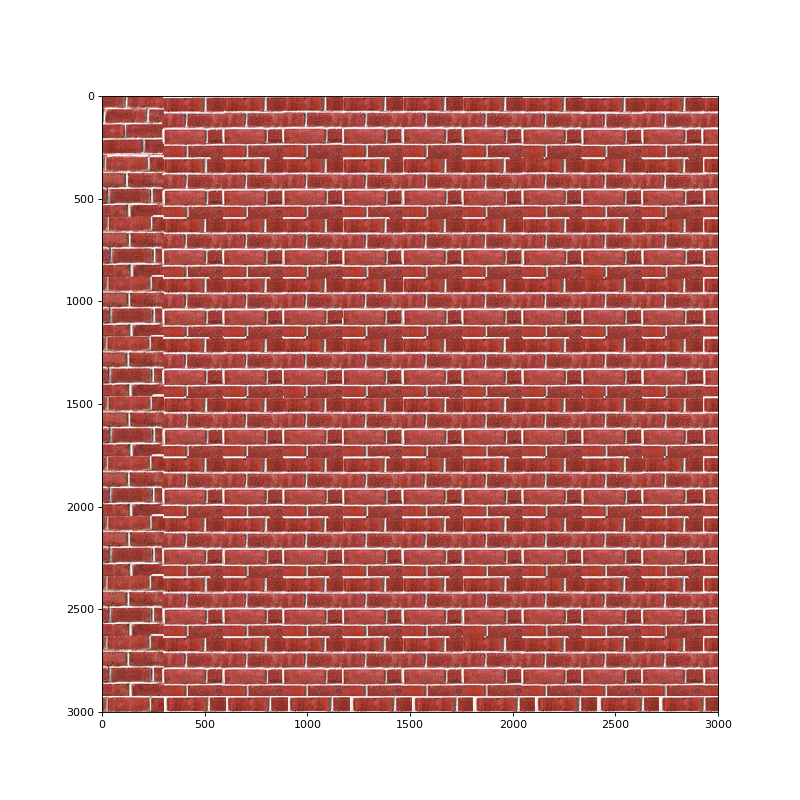

In [247]:
sample_img_dir = 'samples/bricks_large.jpg' # feel free to change
sample_img = None
if os.path.exists(sample_img_dir):
    sample_img = cv2.imread(sample_img_dir)
    sample_img = cv2.cvtColor(sample_img,cv2.COLOR_BGR2RGB)
output = quilt_cut(sample_img, 3000, 301, 10, 20)
output = output.astype('uint8')
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
axes.imshow(output)
plt.savefig('bricks_large_seam_finding.png')

0 69
0 128
0 187
0 246
0 305
0 364
0 423
0 482
0 541
0 600
0 659
0 718
0 777
0 836
0 895
0 954
69 1001
69 69
69 128
69 187
69 246
69 305
69 364
69 423
69 482
69 541
69 600
69 659
69 718
69 777
69 836
69 895
69 954
128 1001
128 69
128 128
128 187
128 246
128 305
128 364
128 423
128 482
128 541
128 600
128 659
128 718
128 777
128 836
128 895
128 954
187 1001
187 69
187 128
187 187
187 246
187 305
187 364
187 423
187 482
187 541
187 600
187 659
187 718
187 777
187 836
187 895
187 954
246 1001
246 69
246 128
246 187
246 246
246 305
246 364
246 423
246 482
246 541
246 600
246 659
246 718
246 777
246 836
246 895
246 954
305 1001
305 69
305 128
305 187
305 246
305 305
305 364
305 423
305 482
305 541
305 600
305 659
305 718
305 777
305 836
305 895
305 954
364 1001
364 69
364 128
364 187
364 246
364 305
364 364
364 423
364 482
364 541
364 600
364 659
364 718
364 777
364 836
364 895
364 954
423 1001
423 69
423 128
423 187
423 246
423 305
423 364
423 423
423 482
423 541
423 600
423 659
423 718
42

<IPython.core.display.Javascript object>


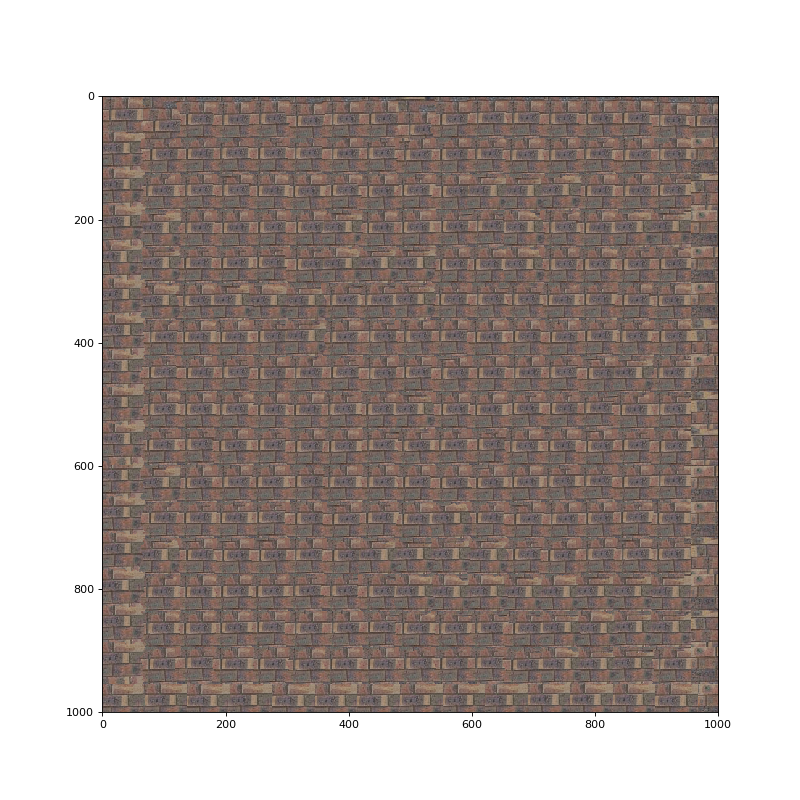

In [248]:
sample_img_dir = 'samples/bricks_small.jpg' # feel free to change
sample_img = None
if os.path.exists(sample_img_dir):
    sample_img = cv2.imread(sample_img_dir)
    sample_img = cv2.cvtColor(sample_img,cv2.COLOR_BGR2RGB)
output = quilt_cut(sample_img, 1000, 69, 10, 20)
output = output.astype('uint8')
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
axes.imshow(output)
plt.savefig('bricks_small_seam_finding.png')

### part IV: Texture Transfer (30 pts)

In [171]:
def texture_transfer(sample, target):
    """
    Feel free to add function parameters
    """
    pass

### Bells & Whistles

(10 pts) Create and use your own version of cut.m. To get these points, you should create your own implementation without basing it directly on the provided function (you're on the honor code for this one). 

You can simply copy your customized_cut(bndcost) into the box below so that it is easier for us to grade

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).